# Run Performance Predictor
- Mimic representative dataset distribution with the WebOfScience dataset.
- Run Performance Predictor (PP) on the mimiced WebOfScience to see if we get similar results as when running against the representative dataset.

The representative dataset has 4 datasets:
- Workspace (wks)
- General (gen) - a general blind test
- Low (low) - a blind test with low accuracy scores
- High (hgh) - a blind test with high accuracy scores

The file `workplace-intent-distribution-max150.csv` has the distributions of how many examples of each intent are in the 4 datasets.
- each row is a different intent
- each column is how many examples of that intent are in the dataset


Mimic the example/intent distributions with the WebOfScience dataset
- Web Of Science has 3 datasets:
  - Web of Science Dataset WOS-11967
    - This dataset contains 11,967 documents with 35 categories which include 7 parents categories.
  - Web of Science Dataset WOS-46985
    - This dataset contains 46,985 documents with 134 categories which include 7 parents categories.
  - Web of Science Dataset WOS-5736
    - This dataset contains 5,736 documents with 11 categories which include 3 parents categories.

Subset the WebOfScience dataset removing some of the parent categories 
- WOS-46985 has 134 intents (need 92 to mimic)
- Removing parent categories [4, 6, 2] leaves 29,919 examples with 97 categories in 4 parent categories
- generate the mimiced datasets from the 29,919 examples.

In [1]:
import gzip
from IPython.display import display, HTML
import io
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.utils import shuffle
import time
from typing import List

from uq360.algorithms.blackbox_metamodel.short_text_classification import ShortTextClassificationWrapper

os.environ["PYTHONWARNINGS"] = 'ignore'

pd.options.display.max_colwidth = 100

%load_ext autoreload
%autoreload 2

# Increase the width of the notebook so that it is the width of the browser 
# which allows larger size for the dashboard
display(HTML('<style>.container { width:100% !important; }</style>'))

2022-08-11 02:16:15.638865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 02:16:15.638904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Load the Web Of Science dataset

In [2]:
%%time
# X is input data that include text sequences 
# Y is target value 
# YL1 is target value of level one (parent label)
# YL2 is target value of level one (child label)
x_gzip_file = '../../../data/WebOfScience/WebOfScience/WOS46985/X.txt.gzip'
y_file = '../../../data/WebOfScience/WebOfScience/WOS46985/Y.txt'
yl1_file = '../../../data/WebOfScience/WebOfScience/WOS46985/YL1.txt'
yl2_file = '../../../data/WebOfScience/WebOfScience/WOS46985/YL2.txt'

with gzip.open(x_gzip_file, 'rt') as f:
    lines = f.readlines()
df_x = pd.DataFrame(lines, columns=['example'])
df_y = pd.read_csv(y_file, header=None, names=['intent'])
df_yl1 = pd.read_csv(yl1_file, header=None, names=['yl1'])
df_yl2 = pd.read_csv(yl2_file, header=None, names=['yl2'])
data = [{'intent': 'y', 
         'n unique': len(np.unique(df_y['intent'])),
         'min n uniq': min(np.unique(df_y['intent'], return_counts=True)[1]),
         'max n uniq': max(np.unique(df_y['intent'], return_counts=True)[1])
        },
        {'intent': 'yl1', 
         'n unique': len(np.unique(df_yl1['yl1'])),
         'min n uniq': min(np.unique(df_yl1['yl1'], return_counts=True)[1]),
         'max n uniq': max(np.unique(df_yl1['yl1'], return_counts=True)[1])
        }
]
display(HTML(pd.DataFrame(data).to_html()))

df_merge = pd.concat([df_x, df_y], axis=1, sort=False)
print(f'df_merge.shape = {df_merge.shape}')

x = df_merge['example'].to_numpy()
y = df_merge['intent'].to_numpy().ravel()
print(f'x.shape        = {x.shape}')
print(f'y.shape        = {y.shape}')

,intent,n unique,min n uniq,max n uniq
0,y,134,43,750
1,yl1,7,3297,14625


df_merge.shape = (46985, 2)
x.shape        = (46985,)
y.shape        = (46985,)
CPU times: user 167 ms, sys: 39.1 ms, total: 206 ms
Wall time: 211 ms


#### Encode with USE encoder

In [3]:
%%time
class MiniLMEmbedding:
    def __init__(self):
        self.transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    def encode(self, input_sentences: List[str]) -> np.array:
        sentences = [sentence.lower() for sentence in input_sentences]
        embedded_sentences = [self.embed_sentence(s) for s in sentences]
        return np.array(embedded_sentences)
    def embed_sentence(self, sentence: str) -> np.array:
        embedding = self.transformer.encode(sentence, show_progress_bar=False, convert_to_numpy=True)
        return embedding

encoded_file = '../../../data/WebOfScience/WebOfScience/WOS46985/X_encoded.csv'
if os.path.exists(encoded_file):
    df = pd.read_csv(encoded_file, header=None)
    x_encoded = df.to_numpy()
else:
    encoder = MiniLMEmbedding()
    x_encoded = encoder.encode(x)
    # Save to file
    df = pd.DataFrame(x_encoded)
    df.to_csv(encoded_file, header=False, index=False)

print(f'x_encoded.shape = {x_encoded.shape}')

x_encoded.shape = (46985, 384)
CPU times: user 4.01 s, sys: 155 ms, total: 4.17 s
Wall time: 4.17 s


#### Determine subset datasert for running experiment
- keep_intents is generated in notebook:
  - 'WebOfScience - filter accuracy ordered classes to 0.80 acc and 90 classes.ipynb'
- representative needs 92, so get a list of keep for highest 92.

In [4]:
keep_intents = [64, 122, 12, 113, 62, 49, 66, 2, 68, 45, 103, 97, 70, 48, 115, 98, 3, 57, 61, 8, 74, 47, 127, 112, 65, 31, 99, 9, 79, 114, 35, 63, 111, 94, 101, 92, 46, 100, 69, 93, 96, 42, 25, 60, 39, 106, 121, 44, 33, 109, 14, 130, 81, 53, 17, 58, 71, 132, 80, 0, 83, 37, 55, 90, 85, 32, 75, 105, 22, 38, 56, 41, 128, 5, 21, 84, 43, 54, 36, 77, 27, 131, 72, 73, 118, 7, 108, 23, 26, 124, 129, 10]
print(f'len(keep_intents) = {len(keep_intents)}')
print(f'keep_intents = {list(keep_intents)}')
# Gather the example indices for the examples to keep
keep_indices = [i for i in range(len(y)) if y[i] in keep_intents]
print(f'len(keep_indices) = {len(keep_indices)}')
y_sub = y[keep_indices]
x_sub_encoded = x_encoded[keep_indices]
print(f'y_sub.shape         = {y_sub.shape}')
print(f'x_sub_encoded.shape = {x_sub_encoded.shape}')

len(keep_intents) = 92
keep_intents = [64, 122, 12, 113, 62, 49, 66, 2, 68, 45, 103, 97, 70, 48, 115, 98, 3, 57, 61, 8, 74, 47, 127, 112, 65, 31, 99, 9, 79, 114, 35, 63, 111, 94, 101, 92, 46, 100, 69, 93, 96, 42, 25, 60, 39, 106, 121, 44, 33, 109, 14, 130, 81, 53, 17, 58, 71, 132, 80, 0, 83, 37, 55, 90, 85, 32, 75, 105, 22, 38, 56, 41, 128, 5, 21, 84, 43, 54, 36, 77, 27, 131, 72, 73, 118, 7, 108, 23, 26, 124, 129, 10]
len(keep_indices) = 34589
y_sub.shape         = (34589,)
x_sub_encoded.shape = (34589, 384)


#### Randomize the dataset

In [5]:
x, y = shuffle(x_sub_encoded, y_sub, random_state=42)
print(f'y_sub.shape         = {y_sub.shape}')
print(f'x_sub_encoded.shape = {x_sub_encoded.shape}')
print(f'y.shape             = {y.shape}')
print(f'x.shape             = {x.shape}')

y_sub.shape         = (34589,)
x_sub_encoded.shape = (34589, 384)
y.shape             = (34589,)
x.shape             = (34589, 384)


## Create datasets from the distributions of the representative datasets

#### load the intent/example distribution of representative datsets
- Each row is a different intent (index)
- Columns are how many examples of that intent are in the dataset (low, high, general or workspaces)

In [6]:
df_distr = pd.read_csv('../../../data/workplace-intent-distribution-max150.csv')

df_distr.sort_values(['df_wks', 'df_gen', 'df_hgh', 'df_low'], ascending=False, inplace=True, ignore_index=True)
print(f'len(df_distr) n_intents = {len(df_distr)}')
print(f'sum datasets n_examples:')
display(HTML(pd.DataFrame({'sum': df_distr.sum()}).to_html()))
print(f'sum columns n_examples  = {df_distr.sum().sum()}')
display(HTML(df_distr.head().to_html()))

len(df_distr) n_intents = 92
sum datasets n_examples:


,sum
df_low,100
df_hgh,523
df_gen,497
df_wks,4496


sum columns n_examples  = 5616


,df_low,df_hgh,df_gen,df_wks
0,3,31,5,111
1,1,32,13,104
2,6,30,11,103
3,2,8,6,101
4,0,16,8,98


#### Create `distr` dictionary to facilitate adding indices to each dataset according to intent
- dictionary keys are the index of the intents
- df_low, df_hgh, df_gen & df_wks columns are the number of examples for each dataset in that intent.
- ..._indices[] is the empty list of example index from the clinic dataset

In [7]:
distr = df_distr.to_dict('index')
for k,v in distr.items():
    v['low_indices'] = []
    v['hgh_indices'] = []
    v['gen_indices'] = []
    v['wks_indices'] = []
display(HTML(pd.DataFrame(distr.values()).head().to_html()))

,df_low,df_hgh,df_gen,df_wks,low_indices,hgh_indices,gen_indices,wks_indices
0,3,31,5,111,[],[],[],[]
1,1,32,13,104,[],[],[],[]
2,6,30,11,103,[],[],[],[]
3,2,8,6,101,[],[],[],[]
4,0,16,8,98,[],[],[],[]


#### Create wks & gen datasets from the distributions of the representative dataset

In [8]:
# np.unique() return_inverse, is a list of the intent index for each of the examples. 
# y_co is a list of the label for each example.
_, return_inverse = np.unique(y, return_inverse=True)
print(f'return_inverse[:10] = {return_inverse[:10]}')

for example_index, intent_index in enumerate(return_inverse):
    # check if intent index is one we want
    if intent_index in distr:
        d = distr[intent_index]
        # If need more indices in workspace then add it
        if d['df_wks'] > len(d['wks_indices']):
            d['wks_indices'].append(example_index)
        # If need more indices in general blind test set then add it
        elif d['df_gen'] > len(d['gen_indices']):
            d['gen_indices'].append(example_index)

# Gather all the wks & gen example indices
# also add to the distr the number of indices for verfication we got what we wanted.
wks_indices = []
gen_indices = []
for k,v in distr.items():
    v['n_wks_indices'] = len(v['wks_indices'])
    v['n_gen_indices'] = len(v['gen_indices'])
    wks_indices.extend(v['wks_indices'])
    gen_indices.extend(v['gen_indices'])

print(f'len(wks_indices)                                           = {len(wks_indices)}')
print(f'len(gen_indices)                                           = {len(gen_indices)}')
print(f'len(wks_indices + gen_indices)                             = {len(wks_indices + gen_indices)}')
print(f'len(np.concatenate((wks_indices, gen_indices)))            = {len(np.concatenate((wks_indices, gen_indices)))}')
print(f'len(np.unique(np.concatenate((wks_indices, gen_indices)))) = {len(np.unique(np.concatenate((wks_indices, gen_indices))))}') 
assert(len(wks_indices + gen_indices) == len(np.unique(np.concatenate((wks_indices, gen_indices)))))

# cols = ['df_low', 'df_hgh', 'df_gen', 'df_wks', 'n_gen_indices', 'n_wks_indices']
# display(HTML(pd.DataFrame(distr.values())[cols].head().to_html()))
# print(list(pd.DataFrame(distr.values()).columns))
display(HTML(pd.DataFrame(distr.values()).head(2).to_html()))

return_inverse[:10] = [19 84 34 48 66 57 14 82  3 43]
len(wks_indices)                                           = 4496
len(gen_indices)                                           = 497
len(wks_indices + gen_indices)                             = 4993
len(np.concatenate((wks_indices, gen_indices)))            = 4993
len(np.unique(np.concatenate((wks_indices, gen_indices)))) = 4993


,df_low,df_hgh,df_gen,df_wks,low_indices,hgh_indices,gen_indices,wks_indices,n_wks_indices,n_gen_indices
0,3,31,5,111,[],[],"[9802, 9933, 10003, 10093, 10111]","[90, 390, 493, 494, 537, 659, 673, 725, 893, 1071, 1086, 1100, 1517, 1576, 1671, 1678, 1770, 1786, 1825, 2060, 2318, 2455, 2466, 2477, 2545, 2795, 2816, 2928, 3000, 3005, 3064, 3155, 3209, 3345, 3442, 3506, 3537, 3800, 3844, 3858, 3971, 3980, 4130, 4206, 4289, 4322, 4330, 4449, 4580, 4616, 4634, 4771, 4793, 4887, 4970, 5001, 5101, 5124, 5171, 5237, 5294, 5355, 5458, 5551, 5611, 5690, 5718, 5751, 5779, 5861, 5916, 5925, 6045, 6084, 6166, 6202, 6304, 6331, 6475, 6542, 6547, 6685, 6983, 7011, 7040, 7504, 7688, 7793, 7795, 7820, 8013, 8057, 8126, 8213, 8439, 8486, 8535, 8700, 8766, 8782, ...]",111,5
1,1,32,13,104,[],[],"[8197, 8278, 8451, 8533, 8620, 8628, 8629, 8636, 8799, 8817, 8879, 8975, 9117]","[52, 122, 137, 223, 412, 477, 657, 685, 718, 777, 846, 851, 876, 946, 987, 1010, 1112, 1135, 1140, 1179, 1221, 1303, 1377, 1483, 1539, 1619, 1695, 1718, 1781, 1819, 1888, 1912, 2011, 2092, 2262, 2266, 2267, 2299, 2376, 2450, 2488, 2701, 2980, 3162, 3175, 3184, 3346, 3463, 3534, 3729, 3922, 4006, 4026, 4182, 4245, 4299, 4535, 4758, 4797, 4798, 4950, 5090, 5191, 5370, 5379, 5434, 5579, 5580, 5702, 5734, 5737, 5786, 5874, 5944, 5959, 6035, 6165, 6196, 6265, 6285, 6326, 6794, 6886, 7012, 7076, 7134, 7136, 7264, 7273, 7291, 7356, 7384, 7461, 7467, 7618, 7731, 7737, 7760, 7786, 7788, ...]",104,13


#### Create a model from the wks indices
- Model is then used to gather the prediction probilibies of the combined dataset
- Excluding the wks & gen indices:
  - The highest probabilites go into the distributions for the hgh dataset
  - The lowest probabilites go into the distributions for the low dataset

In [9]:
%%time
x_trn = x[wks_indices]
y_trn = y[wks_indices]

start = time.time()
model = SVC(probability=True, random_state=42)
model.fit(x_trn, y_trn)
print(f'fit()           dur={time.time() - start}')

start = time.time()
# y_prd = model.predict(x_encoded)
y_pred_proba = model.predict_proba(x)
print(f'predict_proba() dur={time.time() - start}')

fit()           dur=31.506593465805054
predict_proba() dur=102.51723051071167
CPU times: user 2min 13s, sys: 348 ms, total: 2min 14s
Wall time: 2min 14s


#### Highest probabilites go into the distributions for the hgh dataset

In [10]:
# Get max of each row
max_pred_proba = np.amax(y_pred_proba, axis=1)
# print(f'max_pred_proba[:5] = {max_pred_proba[:5]}')
# create dataframe with the max prediction probabilites and indices of the rows
df_pred_proba = pd.DataFrame(max_pred_proba, columns=['max_pred_proba'])
df_pred_proba.reset_index(inplace=True)
# sort high pred_proba to low inorder to have fill in the hgh dataset
df_pred_proba.sort_values(by='max_pred_proba', inplace=True, ascending=False, ignore_index=True)
# display(HTML(df_pred_proba.head().to_html()))
# create list of indices already used in the wks and gen datasets. Simplify check
used_indices = np.concatenate((wks_indices, gen_indices))

# From the remaining indices add the highest probable indices to the high blind test set 
# Stay within the representative distributions
for example_index in df_pred_proba['index'].to_numpy():
    intent_index = return_inverse[example_index]
    if not example_index in used_indices and intent_index in distr:
        d = distr[intent_index]
        if d['df_hgh'] > len(d['hgh_indices']):
            d['hgh_indices'].append(example_index)

# Gather the high indices
# also add to the distr the number of indices for verfication we got what we wanted.
hgh_indices = []
for k,v in distr.items():
    v['n_hgh_indices'] = len(v['hgh_indices'])
    hgh_indices.extend(v['hgh_indices'])

print(f'len(wks_indices)                                                        = {len(wks_indices)}')
print(f'len(gen_indices)                                                        = {len(gen_indices)}')
print(f'len(hgh_indices)                                                        = {len(hgh_indices)}')
print(f'len(wks_indices + gen_indices + hgh_indices)                            = {len(wks_indices + gen_indices+ hgh_indices)}')
print(f'len(np.concatenate((wks_indices, gen_indices, hgh_indices)))            = {len(np.concatenate((wks_indices, gen_indices, hgh_indices)))}')
print(f'len(np.unique(np.concatenate((wks_indices, gen_indices, hgh_indices)))) = {len(np.unique(np.concatenate((wks_indices, gen_indices, hgh_indices))))}') 
assert(len(wks_indices + gen_indices + hgh_indices) == len(np.unique(np.concatenate((wks_indices, gen_indices, hgh_indices)))))


# cols = ['df_low', 'df_hgh', 'df_gen', 'df_wks', 'n_hgh_indices', 'n_gen_indices', 'n_wks_indices']
# display(HTML(pd.DataFrame(distr.values())[cols].head().to_html()))
# print(list(pd.DataFrame(distr.values()).columns))
display(HTML(pd.DataFrame(distr.values()).head(2).to_html()))

len(wks_indices)                                                        = 4496
len(gen_indices)                                                        = 497
len(hgh_indices)                                                        = 523
len(wks_indices + gen_indices + hgh_indices)                            = 5516
len(np.concatenate((wks_indices, gen_indices, hgh_indices)))            = 5516
len(np.unique(np.concatenate((wks_indices, gen_indices, hgh_indices)))) = 5516


,df_low,df_hgh,df_gen,df_wks,low_indices,hgh_indices,gen_indices,wks_indices,n_wks_indices,n_gen_indices,n_hgh_indices
0,3,31,5,111,[],"[18511, 17524, 30343, 32383, 14643, 23305, 14556, 34202, 34580, 22561, 26103, 28392, 17235, 28221, 11089, 19092, 11176, 21551, 28751, 15712, 34584, 25547, 13719, 11716, 24060, 25530, 22530, 22996, 12625, 26779, 11799]","[9802, 9933, 10003, 10093, 10111]","[90, 390, 493, 494, 537, 659, 673, 725, 893, 1071, 1086, 1100, 1517, 1576, 1671, 1678, 1770, 1786, 1825, 2060, 2318, 2455, 2466, 2477, 2545, 2795, 2816, 2928, 3000, 3005, 3064, 3155, 3209, 3345, 3442, 3506, 3537, 3800, 3844, 3858, 3971, 3980, 4130, 4206, 4289, 4322, 4330, 4449, 4580, 4616, 4634, 4771, 4793, 4887, 4970, 5001, 5101, 5124, 5171, 5237, 5294, 5355, 5458, 5551, 5611, 5690, 5718, 5751, 5779, 5861, 5916, 5925, 6045, 6084, 6166, 6202, 6304, 6331, 6475, 6542, 6547, 6685, 6983, 7011, 7040, 7504, 7688, 7793, 7795, 7820, 8013, 8057, 8126, 8213, 8439, 8486, 8535, 8700, 8766, 8782, ...]",111,5,31
1,1,32,13,104,[],"[9148, 34343, 26626, 20390, 22620, 15694, 33982, 25418, 15071, 29058, 18644, 18265, 21520, 22421, 21389, 11848, 14882, 15123, 11251, 11524, 20769, 21081, 14789, 28852, 9800, 10811, 24087, 26308, 19105, 24873, 27431, 10348]","[8197, 8278, 8451, 8533, 8620, 8628, 8629, 8636, 8799, 8817, 8879, 8975, 9117]","[52, 122, 137, 223, 412, 477, 657, 685, 718, 777, 846, 851, 876, 946, 987, 1010, 1112, 1135, 1140, 1179, 1221, 1303, 1377, 1483, 1539, 1619, 1695, 1718, 1781, 1819, 1888, 1912, 2011, 2092, 2262, 2266, 2267, 2299, 2376, 2450, 2488, 2701, 2980, 3162, 3175, 3184, 3346, 3463, 3534, 3729, 3922, 4006, 4026, 4182, 4245, 4299, 4535, 4758, 4797, 4798, 4950, 5090, 5191, 5370, 5379, 5434, 5579, 5580, 5702, 5734, 5737, 5786, 5874, 5944, 5959, 6035, 6165, 6196, 6265, 6285, 6326, 6794, 6886, 7012, 7076, 7134, 7136, 7264, 7273, 7291, 7356, 7384, 7461, 7467, 7618, 7731, 7737, 7760, 7786, 7788, ...]",104,13,32


#### Lowest probabilites go into the distributions for the low dataset

In [11]:
# re-sort from low pred_proba to high inorder to fill in the low dataset
df_pred_proba.sort_values(by='max_pred_proba', inplace=True, ascending=True, ignore_index=True)
# display(HTML(df_pred_proba.head().to_html()))
# create list of indices already used in the wks, gen and hgh datasets. Simplify check
used_indices = np.concatenate((wks_indices, gen_indices, hgh_indices))

# From the remaining indices add the lowest probable indices to the low blind test set 
# Stay within the representative distributions
for example_index in df_pred_proba['index'].to_numpy():
    intent_index = return_inverse[example_index]
    if not example_index in used_indices and intent_index in distr:
        d = distr[intent_index]
        if d['df_low'] > len(d['low_indices']):
            d['low_indices'].append(example_index)

# Gather the low indices
# also add to the distr the number of indices for verfication we got what we wanted.
low_indices = []
for k,v in distr.items():
    v['n_low_indices'] = len(v['low_indices'])
    low_indices.extend(v['low_indices'])

print(f'len(wks_indices)                                                                     = {len(wks_indices)}')
print(f'len(gen_indices)                                                                     = {len(gen_indices)}')
print(f'len(hgh_indices)                                                                     = {len(hgh_indices)}')
print(f'len(low_indices)                                                                     = {len(low_indices)}')
print(f'len(wks_indices + gen_indices + hgh_indices + low_indices)                           = {len(wks_indices + gen_indices + hgh_indices + low_indices)}')
print(f'len(np.concatenate((wks_indices, gen_indices, hgh_indices, low_indices)))            = {len(np.concatenate((wks_indices, gen_indices, hgh_indices, low_indices)))}')
print(f'len(np.unique(np.concatenate((wks_indices, gen_indices, hgh_indices, low_indices)))) = {len(np.unique(np.concatenate((wks_indices, gen_indices, hgh_indices, low_indices))))}') 
assert(len(wks_indices + gen_indices + hgh_indices + low_indices) == len(np.unique(np.concatenate((wks_indices, gen_indices, hgh_indices, low_indices)))))


# cols = ['df_low', 'df_hgh', 'df_gen', 'df_wks', 'n_low_indices', 'n_hgh_indices', 'n_gen_indices', 'n_wks_indices']
# display(HTML(pd.DataFrame(distr.values())[cols].head().to_html()))
# print(list(pd.DataFrame(distr.values()).columns))
display(HTML(pd.DataFrame(distr.values()).head(2).to_html()))

len(wks_indices)                                                                     = 4496
len(gen_indices)                                                                     = 497
len(hgh_indices)                                                                     = 523
len(low_indices)                                                                     = 100
len(wks_indices + gen_indices + hgh_indices + low_indices)                           = 5616
len(np.concatenate((wks_indices, gen_indices, hgh_indices, low_indices)))            = 5616
len(np.unique(np.concatenate((wks_indices, gen_indices, hgh_indices, low_indices)))) = 5616


,df_low,df_hgh,df_gen,df_wks,low_indices,hgh_indices,gen_indices,wks_indices,n_wks_indices,n_gen_indices,n_hgh_indices,n_low_indices
0,3,31,5,111,"[16119, 23280, 31194]","[18511, 17524, 30343, 32383, 14643, 23305, 14556, 34202, 34580, 22561, 26103, 28392, 17235, 28221, 11089, 19092, 11176, 21551, 28751, 15712, 34584, 25547, 13719, 11716, 24060, 25530, 22530, 22996, 12625, 26779, 11799]","[9802, 9933, 10003, 10093, 10111]","[90, 390, 493, 494, 537, 659, 673, 725, 893, 1071, 1086, 1100, 1517, 1576, 1671, 1678, 1770, 1786, 1825, 2060, 2318, 2455, 2466, 2477, 2545, 2795, 2816, 2928, 3000, 3005, 3064, 3155, 3209, 3345, 3442, 3506, 3537, 3800, 3844, 3858, 3971, 3980, 4130, 4206, 4289, 4322, 4330, 4449, 4580, 4616, 4634, 4771, 4793, 4887, 4970, 5001, 5101, 5124, 5171, 5237, 5294, 5355, 5458, 5551, 5611, 5690, 5718, 5751, 5779, 5861, 5916, 5925, 6045, 6084, 6166, 6202, 6304, 6331, 6475, 6542, 6547, 6685, 6983, 7011, 7040, 7504, 7688, 7793, 7795, 7820, 8013, 8057, 8126, 8213, 8439, 8486, 8535, 8700, 8766, 8782, ...]",111,5,31,3
1,1,32,13,104,[15663],"[9148, 34343, 26626, 20390, 22620, 15694, 33982, 25418, 15071, 29058, 18644, 18265, 21520, 22421, 21389, 11848, 14882, 15123, 11251, 11524, 20769, 21081, 14789, 28852, 9800, 10811, 24087, 26308, 19105, 24873, 27431, 10348]","[8197, 8278, 8451, 8533, 8620, 8628, 8629, 8636, 8799, 8817, 8879, 8975, 9117]","[52, 122, 137, 223, 412, 477, 657, 685, 718, 777, 846, 851, 876, 946, 987, 1010, 1112, 1135, 1140, 1179, 1221, 1303, 1377, 1483, 1539, 1619, 1695, 1718, 1781, 1819, 1888, 1912, 2011, 2092, 2262, 2266, 2267, 2299, 2376, 2450, 2488, 2701, 2980, 3162, 3175, 3184, 3346, 3463, 3534, 3729, 3922, 4006, 4026, 4182, 4245, 4299, 4535, 4758, 4797, 4798, 4950, 5090, 5191, 5370, 5379, 5434, 5579, 5580, 5702, 5734, 5737, 5786, 5874, 5944, 5959, 6035, 6165, 6196, 6265, 6285, 6326, 6794, 6886, 7012, 7076, 7134, 7136, 7264, 7273, 7291, 7356, 7384, 7461, 7467, 7618, 7731, 7737, 7760, 7786, 7788, ...]",104,13,32,1


#### Create wks, gen, low & hgh datasets

In [12]:
x_train_encoded = x[wks_indices]
y_train = y[wks_indices]

x_prod_g_encoded = x[gen_indices]
x_prod_l_encoded = x[low_indices]
x_prod_h_encoded = x[hgh_indices]

y_prod_g = y[gen_indices]
y_prod_l = y[low_indices]
y_prod_h = y[hgh_indices]

print(f'x_train_encoded.shape  = {x_train_encoded.shape}')
print(f'y_train.shape          = {y_train.shape}')
print(f'x_prod_g_encoded.shape = {x_prod_g_encoded.shape}')
print(f'y_prod_g.shape         = {y_prod_g.shape}')
print(f'x_prod_l_encoded.shape = {x_prod_l_encoded.shape}')
print(f'y_prod_l.shape         = {y_prod_l.shape}')
print(f'x_prod_h_encoded.shape = {x_prod_h_encoded.shape}')
print(f'y_prod_h.shape         = {y_prod_h.shape}')

x_train_encoded.shape  = (4496, 384)
y_train.shape          = (4496,)
x_prod_g_encoded.shape = (497, 384)
y_prod_g.shape         = (497,)
x_prod_l_encoded.shape = (100, 384)
y_prod_l.shape         = (100,)
x_prod_h_encoded.shape = (523, 384)
y_prod_h.shape         = (523,)


## Run the Performance Predictor (PP) experiments

#### Fit a basic SVM classifier

In [13]:
%%time
def train_model_svm(x, y):
    model = SVC(probability=True, random_state=42)
    model.fit(x, y)    
    return model

model = train_model_svm(x_train_encoded, y_train)

CPU times: user 29.1 s, sys: 50.1 ms, total: 29.1 s
Wall time: 29.1 s


#### Fit the Performance Predictor

In [14]:
%%time
pointwise_features=['confidence_top', 
                    'confidence_delta', 
                    'confidence_entropy', 
                    'class_frequency', 
                    'mlp', 
                    'svc',
                    'predicted_class', 'one_class_svm', 'pca']
calibrator = 'isotonic_regression'
metamodels_considered = {'svm': pointwise_features,
                         'gbm': pointwise_features,
                         'mlp': pointwise_features}

start = time.time()
svc_g_pred = model.predict(x_prod_g_encoded)
print(f'dur={time.time() - start} - svc_g_pred')

start = time.time()
svc_l_pred = model.predict(x_prod_l_encoded)
print(f'dur={time.time() - start} - svc_l_pred')

start = time.time()
svc_h_pred = model.predict(x_prod_h_encoded)
print(f'dur={time.time() - start} - svc_h_pred')

experiments = []
for run in range(5):
    pp = ShortTextClassificationWrapper(base_model=model,
                                        calibrator=calibrator,
                                        metamodels_considered=metamodels_considered)
    # fit PP
    start = time.time()
    pp.fit(x_train_encoded, y_train, x_prod_g_encoded, y_prod_g)
    print(f'{run} dur={time.time() - start} - pp_fitted')

    start = time.time()
    pp_g_accuracy, _, pp_g_score = pp.predict(x_prod_g_encoded)
    print(f'{run} dur={time.time() - start} - pp_g_accuracy  = {pp_g_accuracy / 100}')

    start = time.time()
    pp_l_accuracy, _, pp_l_score = pp.predict(x_prod_l_encoded)
    print(f'{run} dur={time.time() - start} - pp_l_accuracy  = {pp_l_accuracy / 100}')

    start = time.time()
    pp_h_accuracy, _, pp_h_score = pp.predict(x_prod_h_encoded)
    print(f'{run} dur={time.time() - start} - pp_h_accuracy  = {pp_h_accuracy / 100}')

    experiments.append({'run': run,
                        'svc_g_pred': svc_g_pred,
                        'pp_g_accuracy': pp_g_accuracy / 100,
                        'pp_g_score': pp_g_score[0],
                        'svc_l_pred': svc_l_pred,
                        'pp_l_accuracy': pp_l_accuracy / 100,
                        'pp_l_score': pp_l_score[0],
                        'svc_h_pred': svc_h_pred,
                        'pp_h_accuracy': pp_h_accuracy / 100,
                        'pp_h_score': pp_h_score[0],
                       })

dur=1.437143325805664 - svc_g_pred
dur=0.29467082023620605 - svc_l_pred
dur=1.533078670501709 - svc_h_pred
Predictor type : text_ensemble
calibrator : isotonic_regression
metamodels considered: {'svm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'gbm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca'], 'mlp': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc', 'predicted_class', 'one_class_svm', 'pca']}
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
Balancing data encountered a problem. Using unbalanced data.
Balancing data encountered a problem. Using unbalanced data.
Balancing data encountered a problem. Using unbalance

4 dur=512.4033753871918 - pp_fitted
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
4 dur=4.033205270767212 - pp_g_accuracy  = 0.6598643101775912
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
4 dur=0.9955899715423584 - pp_l_accuracy  = 0.5266242847926407
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'one_class_svm', 'pca_1', 'pca_2', 'predicted_class', 'svc_1', 'svc_2']
4 dur=4.643293380737305 - pp_h_accuracy  = 0.7640995323558647
CPU times: user 7min 11s, sys: 2min 41s, total: 9min 52s
Wall time: 9h 42min 32s


#### Summarize results

In [15]:
def check_correctness(intents, y_predictions, y_scores, threshold=0.9):
    n_correct = 0
    true_high = 0
    true_low = 0
    false_high = 0
    false_low = 0
    n_y = len(intents)
    for y, y_pred, y_score in zip(intents, y_predictions, y_scores):
        if y == y_pred:
            n_correct += 1
            if y_score > threshold:
                true_high += 1
            else:
                true_low += 1
        else:
            if y_score > threshold:
                false_high += 1
            else:
                false_low += 1
    acc = n_correct / n_y
    th = true_high / n_y
    tl = true_low / n_y
    fh = false_high / n_y
    fl = false_low / n_y

    return acc, th, tl, fh, fl

,metamodels considered,calibrator,dataset,svc accuracy,pp accuracy,TH,TL,FH,FL,AUC
0,"[svm, gbm, mlp]",isotonic_regression,prod_g,65.39%,65.98%,0.00%,65.39%,0.00%,34.61%,96.80%
1,"[svm, gbm, mlp]",isotonic_regression,prod_g,65.39%,65.99%,0.00%,65.39%,0.00%,34.61%,96.80%
2,"[svm, gbm, mlp]",isotonic_regression,prod_g,65.39%,67.07%,0.00%,65.39%,0.00%,34.61%,97.28%
3,"[svm, gbm, mlp]",isotonic_regression,prod_g,65.39%,67.07%,0.00%,65.39%,0.00%,34.61%,97.27%
4,"[svm, gbm, mlp]",isotonic_regression,prod_g,65.39%,65.99%,0.00%,65.39%,0.00%,34.61%,96.80%
5,"[svm, gbm, mlp]",isotonic_regression,prod_l,18.00%,52.62%,0.00%,18.00%,0.00%,82.00%,55.96%
6,"[svm, gbm, mlp]",isotonic_regression,prod_l,18.00%,52.65%,0.00%,18.00%,0.00%,82.00%,56.20%
7,"[svm, gbm, mlp]",isotonic_regression,prod_l,18.00%,53.28%,0.00%,18.00%,0.00%,82.00%,57.49%
8,"[svm, gbm, mlp]",isotonic_regression,prod_l,18.00%,53.31%,0.00%,18.00%,0.00%,82.00%,57.32%
9,"[svm, gbm, mlp]",isotonic_regression,prod_l,18.00%,52.66%,0.00%,18.00%,0.00%,82.00%,56.13%


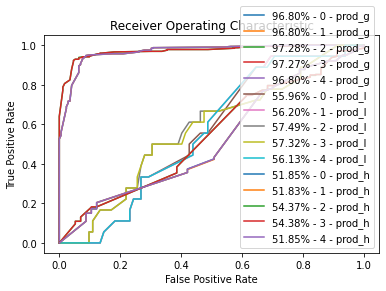

In [16]:
def roc_auc(y_orig, y_pred, pp_score):
    y_true = [1 if y==p else 0 for y,p in zip(y_orig, y_pred)]
    fpr, tpr, thresholds = roc_curve(y_true, pp_score, pos_label=1)
    auc = roc_auc_score(y_true, pp_score)
    return fpr, tpr, auc

plt.figure()
data = []
for e in experiments:
    fpr, tpr, auc = roc_auc(y_prod_g, e['svc_g_pred'], e['pp_g_score'])
    plt.plot(fpr, tpr, label=f'{auc:.2%} - {e["run"]} - prod_g')
    acc, th, tl, fh, fl = check_correctness(y_prod_g,  e['svc_g_pred'],  e['pp_g_score'])
    data.append({#'pointwise features': pointwise_features,
                 'metamodels considered': list(metamodels_considered.keys()),
                 'calibrator': calibrator,
                 'dataset': 'prod_g',
                 'svc accuracy': acc,
                 'pp accuracy': e['pp_g_accuracy'],
                 'TH': th,
                 'TL': tl,
                 'FH': fh,
                 'FL': fl,
                 'AUC': auc,
    })
for e in experiments:
    fpr, tpr, auc = roc_auc(y_prod_l, e['svc_l_pred'], e['pp_l_score'])
    plt.plot(fpr, tpr, label=f'{auc:.2%} - {e["run"]} - prod_l')
    acc, th, tl, fh, fl = check_correctness(y_prod_l,  e['svc_l_pred'],  e['pp_l_score'])
    data.append({#'pointwise features': pointwise_features,
                 'metamodels considered': list(metamodels_considered.keys()),
                 'calibrator': calibrator,
                 'dataset': 'prod_l',
                 'svc accuracy': acc,
                 'pp accuracy': e['pp_l_accuracy'],
                 'TH': th,
                 'TL': tl,
                 'FH': fh,
                 'FL': fl,
                 'AUC': auc,
    })
for e in experiments:
    fpr, tpr, auc = roc_auc(y_prod_h, e['svc_h_pred'], e['pp_h_score'])
    plt.plot(fpr, tpr, label=f'{auc:.2%} - {e["run"]} - prod_h')
    acc, th, tl, fh, fl = check_correctness(y_prod_h,  e['svc_h_pred'],  e['pp_h_score'])
    data.append({#'pointwise features': pointwise_features,
                 'metamodels considered': list(metamodels_considered.keys()),
                 'calibrator': calibrator,
                 'dataset': 'prod_h',
                 'svc accuracy': acc,
                 'pp accuracy': e['pp_h_accuracy'],
                 'TH': th,
                 'TL': tl,
                 'FH': fh,
                 'FL': fl,
                 'AUC': auc,
    })
    
pct_fmt = '{:,.2%}'.format
# fmt = {col: pct_fmt for col in ['svc accuracy', 'pp accuracy', 'TH', 'TL', 'FH', 'FL', 'AUC']}

fmt = {col: pct_fmt for col in ['svc accuracy', 
                                'pp accuracy',
                                'TH',
                                'TL',
                                'FH',
                                'FL',
                                'AUC'
                               ]}

display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

,dataset,svc accuracy,pp accuracy,TH,TL,FH,FL,AUC
0,prod_g,65.39%,65.98%,0.00%,65.39%,0.00%,34.61%,96.80%
1,prod_l,18.00%,52.62%,0.00%,18.00%,0.00%,82.00%,55.96%
2,prod_h,89.10%,76.41%,0.00%,89.10%,0.00%,10.90%,51.85%


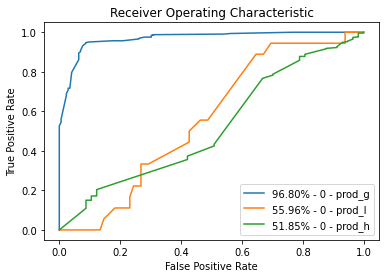

In [17]:
plt.figure()
data = []
for e in experiments:
    fpr, tpr, auc = roc_auc(y_prod_g, e['svc_g_pred'], e['pp_g_score'])
    plt.plot(fpr, tpr, label=f'{auc:.2%} - {e["run"]} - prod_g')
    acc, th, tl, fh, fl = check_correctness(y_prod_g,  e['svc_g_pred'],  e['pp_g_score'])
    data.append({#'pointwise features': pointwise_features,
                 #'metamodels considered': metamodels_considered,
                 #'calibrator': calibrator,
                 'dataset': 'prod_g',
                 'svc accuracy': acc,
                 'pp accuracy': e['pp_g_accuracy'],
                 'TH': th,
                 'TL': tl,
                 'FH': fh,
                 'FL': fl,
                 'AUC': auc,
    })
    break
for e in experiments:
    fpr, tpr, auc = roc_auc(y_prod_l, e['svc_l_pred'], e['pp_l_score'])
    plt.plot(fpr, tpr, label=f'{auc:.2%} - {e["run"]} - prod_l')
    acc, th, tl, fh, fl = check_correctness(y_prod_l,  e['svc_l_pred'],  e['pp_l_score'])
    data.append({#'pointwise features': pointwise_features,
                 #'metamodels considered': metamodels_considered,
                 #'calibrator': calibrator,
                 'dataset': 'prod_l',
                 'svc accuracy': acc,
                 'pp accuracy': e['pp_l_accuracy'],
                 'TH': th,
                 'TL': tl,
                 'FH': fh,
                 'FL': fl,
                 'AUC': auc,
    })
    break
for e in experiments:
    fpr, tpr, auc = roc_auc(y_prod_h, e['svc_h_pred'], e['pp_h_score'])
    plt.plot(fpr, tpr, label=f'{auc:.2%} - {e["run"]} - prod_h')
    acc, th, tl, fh, fl = check_correctness(y_prod_h,  e['svc_h_pred'],  e['pp_h_score'])
    data.append({#'pointwise features': pointwise_features,
                 #'metamodels considered': metamodels_considered,
                 #'calibrator': calibrator,
                 'dataset': 'prod_h',
                 'svc accuracy': acc,
                 'pp accuracy': e['pp_h_accuracy'],
                 'TH': th,
                 'TL': tl,
                 'FH': fh,
                 'FL': fl,
                 'AUC': auc,
    })
    break
    
pct_fmt = '{:,.2%}'.format
# fmt = {col: pct_fmt for col in ['svc accuracy', 'pp accuracy', 'TH', 'TL', 'FH', 'FL', 'AUC']}

fmt = {col: pct_fmt for col in ['svc accuracy', 
                                'pp accuracy',
                                'TH',
                                'TL',
                                'FH',
                                'FL',
                                'AUC'
                               ]}

display(HTML('<h3>WebOfScience dataset</h3>'))
display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()